#### a.) 
Load the data sets, including the train and test matrices as well as the train and test labels. Show the top 20 terms in the decreasing order of total training frequency (total number of occurences of the term across all documents in the training data). Then plot the distribtution of term frequencies in the training data (using a line plot similar to class examples).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
#loading datasets
terms = pd.read_csv('modifiedterms.txt', header=None)
trainMatrix = pd.read_csv('trainMatrixModified.txt', sep='\t', header=None)
testMatrix = pd.read_csv('testMatrixModified.txt', sep='\t', header=None)
trainClass = pd.read_csv('trainClasses.txt',sep='\t', header=None, index_col=0)
testClass = pd.read_csv('testClasses.txt',sep='\t', header=None, index_col=0)
terms.head()

,0
0,david
1,rex
2,wood
3,subject
4,call


In [76]:
#calculate the term frequencies for train matrix
termFreqs = trainMatrix.sum(axis=1)

In [77]:
#sort the highest 20 frequencies
sortedTerms = termFreqs.sort_values(ascending=False)
sortedTerms[:20]

3       959.0
225     720.0
136     680.0
1682    578.0
115     545.0
30      483.0
107     470.0
84      429.0
192     401.0
82      378.0
690     370.0
25      329.0
45      326.0
36      325.0
451     323.0
187     319.0
9       318.0
640     311.0
184     302.0
106     300.0
dtype: float64

Text(0.5, 1.0, 'Frequency of Terms in Descending Order')

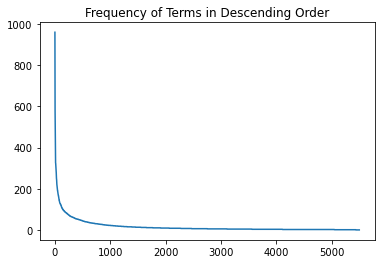

In [78]:
#plot the distribution
plt.plot(sorted(termFreqs, reverse=True))
plt.title("Frequency of Terms in Descending Order")

## Summary
As you can see, the distribution of the term frequency from the training matrix follows a Zipf distribution, which is to be expected given that we're dealing with text categorization.

### b.)
Create your own K-Nearest-Neighbor classifier function. Your classifier should allow as input the training data matrix, the training labels, the instance to be classified, the value of K (number of neighbors), and should return the predicted class for the instance and the indices of the top K neighbors. Your classifier should work with Euclidean distance as well as Cosine distance (which is 1 minus the Cosine similarity). You may create two separate classifiers, or add the distance metric as a parameter in the classifier function (an example implementation of a KNN classifier was provided in class examples). Show that your classifier works by running it on the first two instances in the test data using both Cosine and Euclidean distance in each case.

In [79]:
def knn_search(x, D, K, measure):
    """ find K nearest neighbors of an instance x among the instances in D """
    if measure == 0:
        # euclidean distances from the other points
        dists = np.sqrt(((D - x)**2).sum(axis=1))
    elif measure == 1:
        # first find the vector norm for each instance in D as wel as the norm for vector x
        D_norm = np.array([np.linalg.norm(D[i]) for i in range(len(D))])
        x_norm = np.linalg.norm(x)
        # Compute Cosine: divide the dot product o x and each instance in D by the product of the two norms
        sims = np.dot(D,x)/(D_norm * x_norm)
        # The distance measure will be the inverse of Cosine similarity
        dists = 1 - sims
    idx = np.argsort(dists) # sorting
    # return the indexes of K nearest neighbors
    return idx[:K], dists

In [80]:
def knn_classify(x, D, K, labels, measure):
    from collections import Counter
    neigh_idx, distances = knn_search(x, D, K, measure)
    neigh_labels = labels[neigh_idx]
    count = Counter(neigh_labels)
    print("Labels for top ", K, "neighbors: ", count.most_common())
    return count.most_common(1)[0][0]

In [81]:
#Transpose training/test matrix
trainMatrixT = trainMatrix.T
testMatrixT = testMatrix.T

In [183]:
#convert trainMatrixT to np array for search function, get test instances
trainArray = np.array(trainMatrixT)
x = np.array(testMatrixT.iloc[1])
y = np.array(testMatrixT.iloc[2])
x.shape, trainArray.shape

((5500,), (800, 5500))

In [264]:
#knn search test
n, dist = knn_search(y, trainArray, 5, 1)

In [185]:
dist = pd.Series(dist)
dist.sort_values()

453    0.712351
688    0.750415
519    0.750870
177    0.794804
486    0.821767
         ...   
149    0.992854
330    0.993175
18     0.993264
555    0.994516
122    0.995560
Length: 800, dtype: float64

In [186]:
trainClass.columns = range(1)
type(trainClass[0])

pandas.core.series.Series

In [187]:
#knn classifcation test - Euclidean, First Test Instance
testX0 = knn_classify(x, trainArray, 5, trainClass[0], 0)
testX0

Labels for top  5 neighbors:  [(0, 3), (1, 2)]


0

In [188]:
#knn classifcation test - Cosine Similarity, First Test Instance
testX1 = knn_classify(x, trainArray, 5, trainClass[0], 1)
testX1

Labels for top  5 neighbors:  [(0, 5)]


0

In [189]:
#knn classifcation test - Euclidean, Second Test Instance
testY0 = knn_classify(y, trainArray, 5, trainClass[0], 0)
testY0

Labels for top  5 neighbors:  [(0, 3), (1, 2)]


0

In [190]:
#knn classifcation test - Cosine Similarity, Second Test Instance
testY0 = knn_classify(y, trainArray, 5, trainClass[0], 1)
testY0

Labels for top  5 neighbors:  [(0, 5)]


0

## Summary
As you can see, we were able to classfiy the first two instances of the test matrix utilizing cosine similarity/distances and euclidean distance formulas. For the first instance using Euclidean, we had 3 neighbors with a class label 0, or Microsoft Windows, and 2 labels with a class label 1, or Hockey. Therefore, our classfier put the new test instance in the class label 0, since 3 neighbors wins by majority. In the Cosine example, all 5 neighbors are classified with a class label of 0. For our second instance, we can use similar reasoning and deduction as our first instance.

### c.)
Create an evaluation function to measure the accuracy of your classifier. This function will call the classifier function in part a on all the test instances and in each case compares the actual test class label to the predicted class label. It should take as input the training data, the training labels, the test instances, the labels for test instances, and the value of K. Your evaluation function should return the Classification Accuracy (ratio of correct predictions to the number of test instances)

In [194]:
#new evaluate function
def knn_classify(x, D, K, labels, measure):
    from collections import Counter
    neigh_idx, distances = knn_search(x, D, K, measure)
    neigh_labels = labels[neigh_idx]
    count = Counter(neigh_labels)
    # print("Labels for top ", K, "neighbors: ", count.most_common())
    predicted_label = count.most_common(1)[0][0]
    return neigh_idx, predicted_label

In [195]:
def knn_evaluate(test, test_labs, train, train_labs, K, measure):
    T = 0
    F = 0
    for i in range(len(test)):
        actual = test_labs[i]
        top_K_neighbors, predicted = knn_classify(test[i], train, K, train_labs, measure)
        if actual == predicted:
            T += 1
        else:
            F += 1
    accuracy = float(T) / float(T + F)
    return accuracy

In [198]:
testArray = np.array(testMatrixT)
testArray

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [199]:
testClass.columns = range(1)
type(testClass[0])

pandas.core.series.Series

In [204]:
accruacy_euclid = knn_evaluate(testArray, testClass[0] , trainArray, trainClass[0], 5, 0)

In [205]:
accruacy_euclid

0.815

In [208]:
accruacy_cosine = knn_evaluate(testArray, testClass[0] , trainArray, trainClass[0], 5, 1)

In [209]:
accruacy_cosine

0.97

## Summary
For this part, we are taking each instance in the test dataset, performing our KNN prediction with 5 neighbors on the given distance metric, and recording if our prediction is correct. After collecting all the correct/incorrect predictions, we are able to calculate an accruacy metric, which is what is being returned. As you can see, the cosine accruacy is significantly higher than the euclidean accruacy, and this makes sense since we are dealing with a lot of sparse data. The cosine similarity function is able to deal with this sparse data a lot better than the eucldiean distance function.

### d.)
Run your evaluation function on a range of values for K from 5 to 100 (in increments of 5) in order to compare accuracy values for different numbers of neighbors. Do this both using Euclidean Distance as well as Cosine similarity measure. Present the results as graphs with K in the x-axis and the evaluation metric (accuracy) on the y-axis. Use a single plot to compare the two version of the classifier (Euclidean distance version vs. cosine similarity version).

In [211]:
#Euclidean Distance
res = []
for i in range(5,101,5):
    res.append(knn_evaluate(testArray, testClass[0] , trainArray, trainClass[0], i, 0))
res

[0.815,
 0.85,
 0.785,
 0.765,
 0.73,
 0.725,
 0.69,
 0.7,
 0.655,
 0.67,
 0.655,
 0.66,
 0.625,
 0.625,
 0.63,
 0.615,
 0.615,
 0.61,
 0.605,
 0.605]

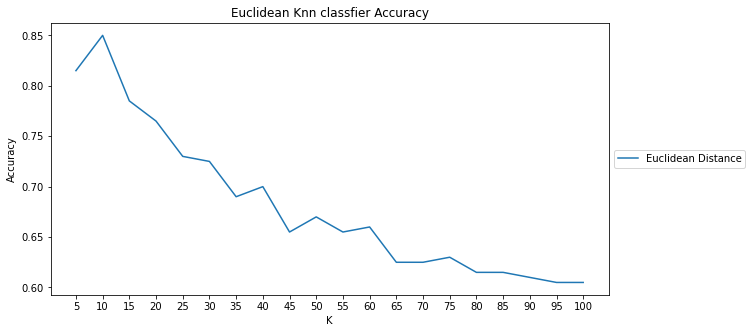

In [213]:
K = list(range(5,101,5))
plt.figure(figsize=(10,5))
plt.plot(K, res, label = 'Euclidean Distance')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Euclidean Knn classfier Accuracy')
plt.xticks(K)
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

In [214]:
#Cosine Similarity
res2 = []
for i in range(5,101,5):
    res2.append(knn_evaluate(testArray, testClass[0] , trainArray, trainClass[0], i, 1))
res2

[0.97,
 0.985,
 0.985,
 0.975,
 0.97,
 0.98,
 0.98,
 0.98,
 0.975,
 0.98,
 0.975,
 0.98,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975]

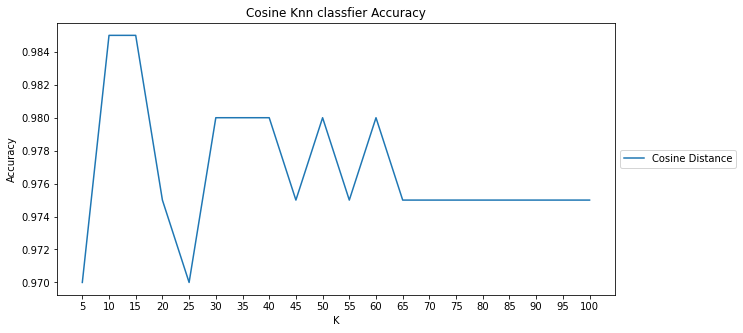

In [216]:
K = list(range(5,101,5))
plt.figure(figsize=(10,5))
plt.plot(K, res2, label = 'Cosine Distance')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Cosine Knn classfier Accuracy')
plt.xticks(K)
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

## Summary
Using a range of different neighbor values from 5 to 100 in increments of 5, we get 20 accruacy statistics when utilizing our knn_evaluate function. Looking at the Euclidean distance, we can evidently see that the K value matters, and should be picked somewhere between 5 - 10 nearest neighbors. For our Cosine distance however, the value for K doesn't have too much of an impact on the accruacy, but we get the best accruacy with values between 5 - 15.

### e.)
Next, modify the training and test data sets so that term weights are converted to TFxIDF weights (instead of raw term frequencies). [See class notes on Text Categorization]. Then, rerun your evaluation (only for the Cosine similarity version of the classifier) on the range of K values (as above) and create a chart comparing the results with and without using TFxIDF weights.

In [217]:
#calculate doc frequencies for each term
DF = pd.DataFrame([(trainMatrix!=0).sum(1)]).T
DF

,0
0,50
1,7
2,10
3,800
4,108
...,...
5495,3
5496,3
5497,2
5498,2


In [219]:
#create 800 doc matrix
NMatrix=np.ones(np.shape(trainMatrix),dtype=float)*800
print(NMatrix)

[[800. 800. 800. ... 800. 800. 800.]
 [800. 800. 800. ... 800. 800. 800.]
 [800. 800. 800. ... 800. 800. 800.]
 ...
 [800. 800. 800. ... 800. 800. 800.]
 [800. 800. 800. ... 800. 800. 800.]
 [800. 800. 800. ... 800. 800. 800.]]


In [220]:
#calc the inverse doc frequency
IDF = np.log2(np.divide(NMatrix, np.array(DF)))
IDF

array([[4.  , 4.  , 4.  , ..., 4.  , 4.  , 4.  ],
       [6.84, 6.84, 6.84, ..., 6.84, 6.84, 6.84],
       [6.32, 6.32, 6.32, ..., 6.32, 6.32, 6.32],
       ...,
       [8.64, 8.64, 8.64, ..., 8.64, 8.64, 8.64],
       [8.64, 8.64, 8.64, ..., 8.64, 8.64, 8.64],
       [8.64, 8.64, 8.64, ..., 8.64, 8.64, 8.64]])

In [222]:
#use IDF weights to create the tfidf matrix
TD_tfidf = trainMatrix * IDF
TD_tfidf

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,8.000000,0.000000,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,13.673003,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.509504,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,12.643856,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,23.111750,2.888969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.777937,0.0,0.0,0.0,0.0,0.0,0.0,2.888969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5495,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5496,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5497,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5498,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [223]:
#transpose, create np array
DT_tfidf = TD_tfidf.T
DT_tfidfArray = np.array(DT_tfidf)

In [224]:
#calculate tfidf accruacy for cosine distance
res3 = []
for i in range(5,101,5):
    res3.append(knn_evaluate(testArray, testClass[0] , DT_tfidfArray, trainClass[0], i, 1))
res3

[0.97,
 0.995,
 0.995,
 0.995,
 0.99,
 0.99,
 0.98,
 0.99,
 0.98,
 0.985,
 0.985,
 0.99,
 0.98,
 0.985,
 0.98,
 0.985,
 0.985,
 0.98,
 0.98,
 0.99]

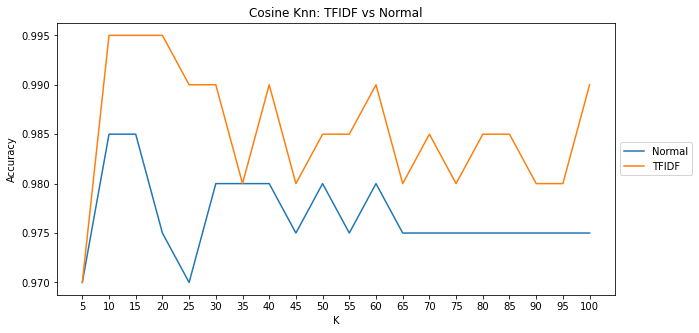

In [225]:
K = list(range(5,101,5))
plt.figure(figsize=(10,5))
plt.plot(K, res2, label = 'Normal')
plt.plot(K, res3, label = 'TFIDF')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Cosine Knn: TFIDF vs Normal')
plt.xticks(K)
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

## Summary
For this part, we calculated the IDF weights and applied them to our original training data matrix. We then transposed this, and performed our evaluate classifer function and compared it to our original cosine distance accruacy values. From the above graph, we can see that the accruacy of the TFIDF values is generally higher for all instances of k neighbors. This makes sense, since the IDF weights are supposed to normalize the matrix, and put less weight on terms that appear in the majority of the documents, while placing more weight on terms that are signficant in a smaller amount of the documents.

### f.)
Create a new classifier based on the Rocchio Method (also know as the "nearest centroid" method) adapted for text categorization [See class notes on Text Categorization]. You should separate the training function from the classification function. The training part for the classifier can be implemented as a function that takes as input the training data matrix and the training labels, returning the prototype vectors for each class. The classification part can be implemented as another function that would take as input the prototypes returned from the training function and the instance to be classified. This function should measure Cosine similarity of the test instance to each prototype vector. Your output should indicate the predicted class for the test instance and the similarity values of the instance to each of the category prototypes.  Finally, use your evaluation function to compare your results to the best KNN results you obtained in part d. [Note: your functions should work regardless of the number of categories (class labels) and should not be limited to two-class categorization scenario. The number of classes should not be hardcoded in your implementation.]

In [262]:
def rocchioTrain(trainMat, trainLab):
    '''takes in training matrix and labels and returns prototype vector for each class in a dict'''
    d = {}
    for i in range(len(trainLab)):
        if trainLab[i] not in d.keys():
            d[trainLab[i]] = trainMat[i]
        else:
            d[trainLab[i]] += trainMat[i]
    return d

In [263]:
d = rocchioTrain(DT_tfidfArray, trainClass[0])
d

{0: array([228.  ,  27.35,  31.61, ...,   8.64,  17.29,  17.29]),
 1: array([578.  , 445.86, 505.47, ..., 406.64, 398.  , 398.  ])}

In [288]:
def rocchioClassify(x, trainMat, trainLab):
    '''utilizes above function, uses cosine similarity and returns the classifcation and similarity values'''
    
    d = rocchioTrain(trainMat, trainLab)
    sims = []
    cls = 0
    D_norm = np.array([np.linalg.norm(d[i]) for i in range(len(d))])
    x_norm = np.linalg.norm(x)
    #For each prototype, compute and record a similarity score
    for i in range(len(d)):
        sims.append([np.dot(d[i],x)/(D_norm[i] * x_norm)])
    #Find the index/class with the highest similarity score
    for i in range(len(sims)):
        if sims[cls] < sims[i]:
            cls = i
    return sims, cls

In [289]:
rocchioClassify(x, DT_tfidfArray, trainClass[0])

([[0.24380936475081125], [0.08172396766551054]], 0)

In [292]:
def rocchioEvaluate(test, test_labs, train, train_labs):
    T = 0
    F = 0
    for i in range(len(test)):
        actual = test_labs[i]
        similarities, predicted = rocchioClassify(test[i], train, train_labs)
        if actual == predicted:
            T += 1
        else:
            F += 1
    accuracy = float(T) / float(T + F)
    return accuracy

In [293]:
#Calculate Accruacy
acc =rocchioEvaluate(testArray, testClass[0] , DT_tfidfArray, trainClass[0])
acc

0.98

## Summary
After creating our Rocchio train, classify, and evaluate functions, we are able to test the accruacy of our classifier against the test data. We get an accuracy score of .98, which tops the .85 for Euclidean distance and is in line with the .98 for cosine distance that we calculated in part d.

### g.)
Using scikit-learn's Nearest Centroid classifier to perform classification of the test instances, as in the previous part. Compare the classification accuracy of your Rocchio implementation to the classification results using scikit-learn.

In [308]:
from sklearn.neighbors import NearestCentroid

In [313]:
#create centroid object, fit training data
clf = NearestCentroid()
clf.fit(trainArray, trainClass[0])

NearestCentroid()

In [315]:
clf.predict(testArray)

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1])

In [316]:
print(clf.score(testArray, testClass[0]))

0.94


## Summary
Looking at our accuracy score of .94 for the sklearn Nearest Centroid method, we can see that it is less than the .98 we got with our rocchio function. One reason for this might be due to the fact that we used IDF weights training matrix for part f.) and our original training matrix for part g.)

# Problem #2

### a.)
Load the data into a Pandas dataframe. Create dummy variables for the categorical attributes so that the data set is fully numeric. Then separate the attribute ("income_>50K") from the remaining attributes; this will be used as the target attribute for classification.  [Note: you need to drop "income_<=50K" which is also created as a dummy variable in earlier step]. Finally, split the transformed data into training and test sets (using 80%-20% randomized split). Note: use the train_test_split function from the sklearn.model_selection module with random_state = 111 to perform the split.

In [12]:
#load data
census_df = pd.read_csv('adult-modified.csv')
census_df.head()

,age,workclass,education,marital-status,race,sex,hours-per-week,income
0,39,Public,13,Single,White,Male,40,<=50K
1,50,Self-emp,13,Married,White,Male,13,<=50K
2,38,Private,9,Single,White,Male,40,<=50K
3,53,Private,7,Married,Black,Male,40,<=50K
4,28,Private,13,Married,Black,Female,40,<=50K


In [13]:
#create dummies for categorical attributes
census_dum = pd.get_dummies(census_df[['age','workclass','education','marital-status','race','sex','hours-per-week',
                                       'income']])
census_dum.head()

,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male,income_<=50K,income_>50K
0,39,13,40,0,1,0,0,1,0,0,0,0,1,0,1,1,0
1,50,13,13,0,0,1,1,0,0,0,0,0,1,0,1,1,0
2,38,9,40,1,0,0,0,1,0,0,0,0,1,0,1,1,0
3,53,7,40,1,0,0,1,0,0,0,1,0,0,0,1,1,0
4,28,13,40,1,0,0,1,0,0,0,1,0,0,1,0,1,0


In [14]:
#drop income from dummy df, store it in target matrix
census_target = census_df['income']
census_dum = census_dum.drop(['income_<=50K', 'income_>50K'], axis=1)
census_dum.head()

,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male
0,39,13,40,0,1,0,0,1,0,0,0,0,1,0,1
1,50,13,13,0,0,1,1,0,0,0,0,0,1,0,1
2,38,9,40,1,0,0,0,1,0,0,0,0,1,0,1
3,53,7,40,1,0,0,1,0,0,0,1,0,0,0,1
4,28,13,40,1,0,0,1,0,0,0,1,0,0,1,0


In [15]:
#split data 80/20 using sklearn train_test_split rs=111
from sklearn.model_selection import train_test_split
census_train, census_test, census_target_train, census_target_test = train_test_split(census_dum, census_target, test_size=.2,random_state=111)

print(census_test.shape)
print(census_train.shape)
print(census_target_test.shape)
print(census_target_train.shape)
census_test.head()

(1883, 15)
(7529, 15)
(1883,)
(7529,)


,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male
1699,22,7,35,1,0,0,1,0,0,0,1,0,0,1,0
542,26,10,45,0,0,1,1,0,0,0,0,0,1,0,1
2985,59,9,40,1,0,0,0,1,0,0,1,0,0,1,0
699,32,10,40,1,0,0,0,1,0,0,1,0,0,1,0
1090,38,13,60,1,0,0,1,0,0,0,0,0,1,0,1


### b.)
Use scikit-learn's KNN implementation for classification.

#### i.)
First normalize the data so that all attributes are in the same scale (normalize so that the values are between 0 and 1). Run your KNN classifier using K=10. Generate the confusion matrix (visualize it using Matplotlib) as well as the classification report. Report the model accuracy for both the training and the test sets.

In [16]:
#normalize data
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler().fit(census_train)

census_train_norm = min_max_scaler.transform(census_train)
census_train_norm = pd.DataFrame(census_train_norm, columns=census_train.columns, index=census_train.index)

census_test_norm = min_max_scaler.transform(census_test)
census_test_norm = pd.DataFrame(census_test_norm, columns=census_test.columns, index = census_test.index)

In [17]:
census_train_norm.head()

,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male
8487,0.178082,0.600000,0.397959,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2218,0.273973,0.266667,0.500000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7839,0.397260,0.533333,0.397959,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1914,0.082192,0.800000,0.397959,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7147,0.602740,0.533333,0.551020,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [18]:
 census_test_norm.head()

,age,education,hours-per-week,workclass_Private,workclass_Public,workclass_Self-emp,marital-status_Married,marital-status_Single,race_Amer-Indian,race_Asian,race_Black,race_Hispanic,race_White,sex_Female,sex_Male
1699,0.068493,0.400000,0.346939,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
542,0.123288,0.600000,0.448980,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2985,0.575342,0.533333,0.397959,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
699,0.205479,0.600000,0.397959,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1090,0.287671,0.800000,0.602041,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [19]:
#Fit Knn classifier
from sklearn import neighbors
n_neighbors = 10

knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(census_train_norm, census_target_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [20]:
#predict labels for test data
knnpreds_test = knnclf.predict(census_test_norm)
knnpreds_test

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      dtype=object)

In [21]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
knncm = confusion_matrix(census_target_test, knnpreds_test)
print(knncm)

[[1256  161]
 [ 240  226]]


Text(0.5, 0, 'Predicted')

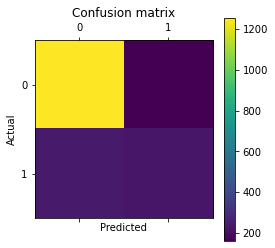

In [22]:
#Graph CM
plt.matshow(knncm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [23]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(census_target_test, knnpreds_test))

              precision    recall  f1-score   support

       <=50K       0.84      0.89      0.86      1417
        >50K       0.58      0.48      0.53       466

    accuracy                           0.79      1883
   macro avg       0.71      0.69      0.70      1883
weighted avg       0.78      0.79      0.78      1883



In [24]:
#Train Score
knnclf.score(census_train_norm, census_target_train)

0.9432859609509895

In [25]:
#Test Score
knnclf.score(census_test_norm, census_target_test)

0.7870419543281997

## Summary
For our scores, we get a .94 accuracy predicting the training data and .78 accuracy of predicting the test data. This tells us that we could be overfitting our model, since the test accuracy is significantly less. We can also see from the classifcation report and confusion matrix that our model is a lot better at predicting the <=50K instances, but the smaller sample >50K only had a 58% precision.

#### ii.)
Next, experiment with different values of K (say from 5 to 100) and the weight parameter (i.e., with or without distance weighting) to see if you can improve accuracy of the KNN classifier. Show the results in a single plot comparing distance and uniform weighting schemes across the different values of K. Use the best values of these parameter (K and weighting scheme) to train a new KNN classifier and report the accuracy of this classifier on the training and test sets.

In [26]:
def knnClassifier(K, w):
    '''takes in a K value and whether there should be distance weighting an returns the accuracies'''
    acc = []
    if w == 0:
        w = 'uniform'
    elif w == 1:
        w = 'distance'
    for i in range(5, K+1):
        knnclf = neighbors.KNeighborsClassifier(i, weights=w)
        knnclf.fit(census_train_norm, census_target_train)
        acc.append(knnclf.score(census_test_norm, census_target_test))
    return acc
        

In [27]:
knnWeighted = knnClassifier(100, 1)
knnUniform = knnClassifier(100, 0)

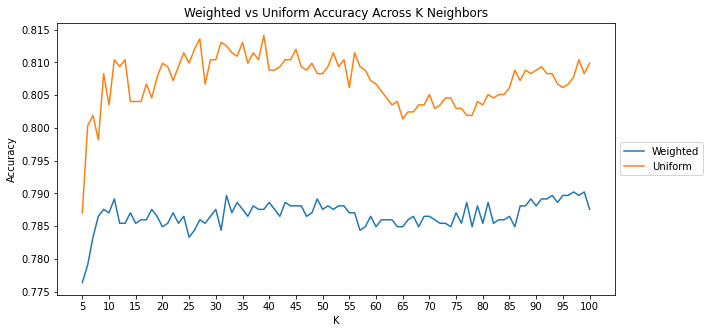

In [28]:
#weighted vs uniform graph
K = list(range(5,101))
plt.figure(figsize=(10,5))
plt.plot(K, knnWeighted, label = 'Weighted')
plt.plot(K, knnUniform, label = 'Uniform')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Weighted vs Uniform Accuracy Across K Neighbors')
plt.xticks(range(5,101,5))
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

In [29]:
#Find best accuracy/index
uni_df = pd.DataFrame(knnUniform, index=K)
uni_df.idxmax(), uni_df.max()

(0    39
 dtype: int64,
 0    0.814126
 dtype: float64)

In [30]:
#Weight = uniform, neighbors = 39
knnclf = neighbors.KNeighborsClassifier(39, weights='uniform')
knnclf.fit(census_train_norm, census_target_train)

KNeighborsClassifier(n_neighbors=39)

In [31]:
#acc train
knnclf.score(census_train_norm, census_target_train)

0.8217558772745385

In [32]:
#acc test
knnclf.score(census_test_norm, census_target_test)

0.8141263940520446

## Summary
Once we were able to find the optimal parameters for our classifier (uniform, neighbors=39), we were able to record a similar train and test accuracy score (.8217, .8141), indicating that our model is no longer overfitting, while improving the accuracy on unseen or test data.

#### iii.)
Next, using only "uniform" weights, compare the accuracy of the KNN classifier across the different values of K on the training and the test data. You should show the results in a single figure with two line plots for the test and training accuracy values (y-axis) and with values of K in the x-axis. What range of values of K represent overfitting? Briefly explain.

In [33]:
def knnClassifier2(K, w, mat, cls):
    '''takes in additional parameters to determine the matrix/class scores'''
    acc = []
    if w == 0:
        w = 'uniform'
    elif w == 1:
        w = 'distance'
    for i in range(5, K+1):
        knnclf = neighbors.KNeighborsClassifier(i, weights=w)
        knnclf.fit(census_train_norm, census_target_train)
        acc.append(knnclf.score(mat, cls))
    return acc

In [34]:
knn_uni_train = knnClassifier2(100, 0, census_train_norm, census_target_train)
knn_uni_test = knnClassifier2(100, 0, census_test_norm, census_target_test)

In [35]:
len(knn_uni_test)

96

In [36]:
len(knn_uni_train)

96

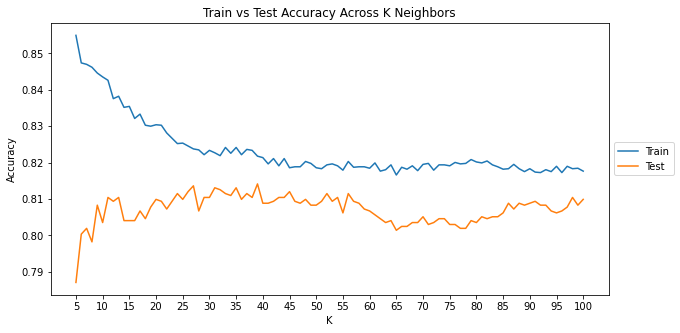

In [37]:
#weighted vs uniform graph
K = list(range(5,101))
plt.figure(figsize=(10,5))
plt.plot(K, knn_uni_train, label = 'Train')
plt.plot(K, knn_uni_test, label = 'Test')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy Across K Neighbors')
plt.xticks(range(5,101,5))
plt.legend(loc='center left',bbox_to_anchor=(1,.5))

## Summary
From the graph, you can easily see how the differences in accuracy changes over the value picked for K. The trend for the training data looks like a Zipf distribution, with accuracy getting lower with more K neighbors utilized. In K<20, there is evidence that our model is overfitting for these values since the train data accuracy is a lot higher than the test data accuracy. From 25<=K<=55, we have our sweet spot of K values, as all of these have minimal differences from test and train. 

### c.)
Using the non-normalized training and test data, perform classification using scikit-learn's decision tree classifier (using the default parameters). As above, generate the confusion matrix, classification report, and average accuracy scores of the classifier. Compare the average accuracy score on the test and the training data sets. What does the comparison tell you in terms of bias-variance trade-off? Next, create another decision tree model (trained on the non-normalized training data) using "gini" index as the selection criteria, min_samples_split=10, and max_depth=4. Show the accuracy results for both the training and test sets. For this model generate a visualization of tree embedded in the Jupyter Notebook.

In [38]:
from sklearn import tree

In [39]:
#create/fit dtree classifier
treeclf = tree.DecisionTreeClassifier()
treeclf.fit(census_train, census_target_train)

DecisionTreeClassifier()

In [40]:
#predict labels for test data, generate confusion matrix
treepreds_test = treeclf.predict(census_test)
treecm = confusion_matrix(census_target_test, treepreds_test)
print(treecm)

[[1196  221]
 [ 256  210]]


Text(0.5, 0, 'Predicted')

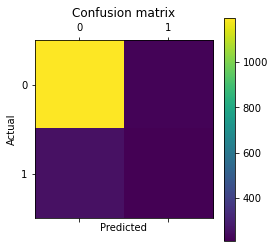

In [41]:
#Graph CM
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [42]:
#Classification Report
print(classification_report(census_target_test, treepreds_test))

              precision    recall  f1-score   support

       <=50K       0.82      0.84      0.83      1417
        >50K       0.49      0.45      0.47       466

    accuracy                           0.75      1883
   macro avg       0.66      0.65      0.65      1883
weighted avg       0.74      0.75      0.74      1883



In [43]:
#Train Score
treeclf.score(census_train, census_target_train)

0.9432859609509895

In [44]:
#Test Score
treeclf.score(census_test, census_target_test)

0.7466808284652151

#### Comparison of Train/Test Scores
The train accuracy score of .94 versus the test score of .75 shows that our current model is likely overfitting the training data. This is because it does significantly worse when trying to classify unseen data, or the test data. Therefore, this model has high variance and low bias since we pay too much attention to the training data and don't generalize enough for the unseen data

In [45]:
#Second classifier with criteria
treeclf2 = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=10, max_depth=4)
treeclf2.fit(census_train, census_target_train)

DecisionTreeClassifier(max_depth=4, min_samples_split=10)

In [46]:
#Train Score
treeclf2.score(census_train, census_target_train)

0.817638464603533

In [47]:
#Test Score
treeclf2.score(census_test, census_target_test)

0.8130642591609134

In [48]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [49]:
import graphviz

In [50]:
from sklearn.tree import export_graphviz

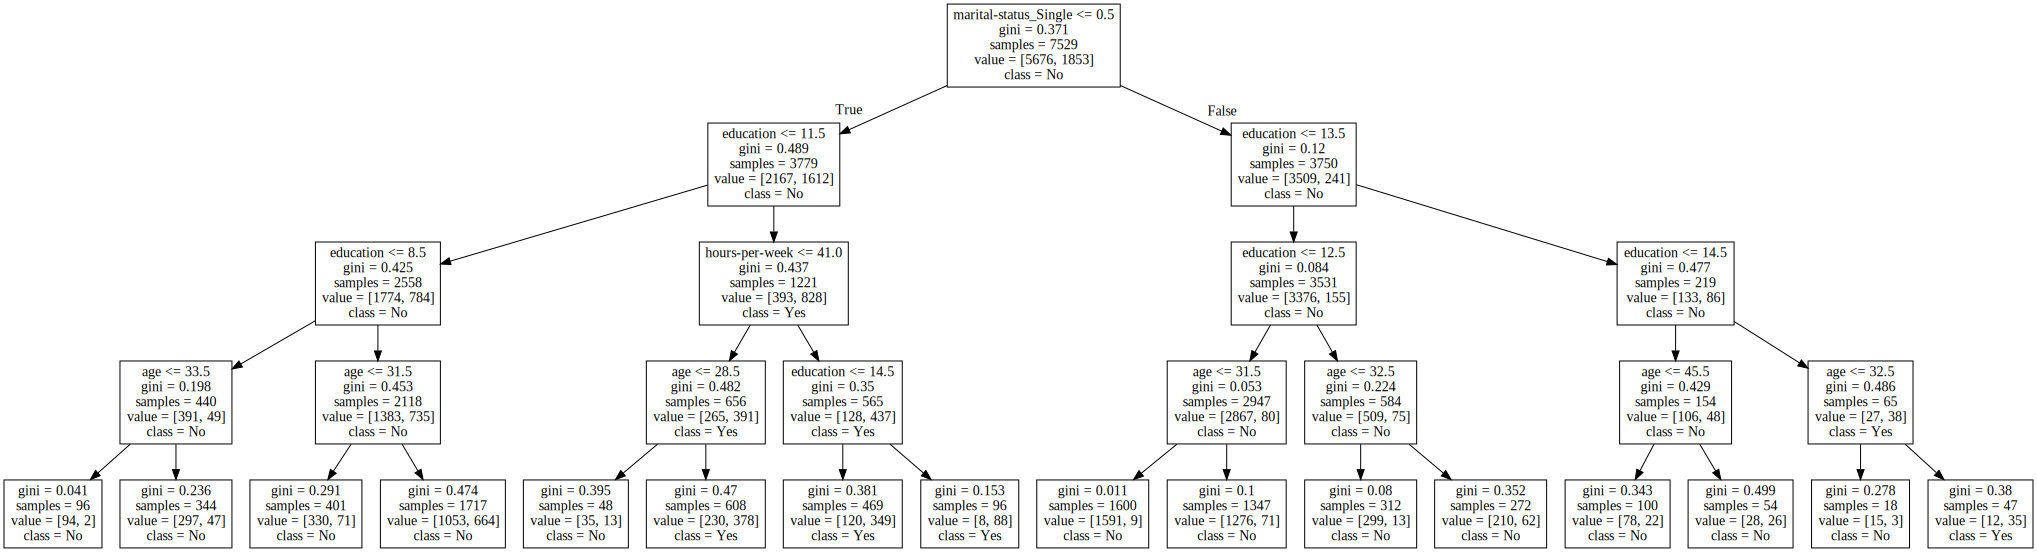

In [51]:
export_graphviz(treeclf2,out_file='tree.dot', feature_names=census_train.columns, class_names=["No","Yes"])

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### d.)
Use scikit-learn to build classifiers using Naive Bayes (Gaussian) and linear discriminant analysis (LDA).  For each of these perform 10-fold cross-validation on the 80% training data (using cross-validation module in scikit-learn) and report the overall average accuracy. Compare this cross-validation accuracy to the model accuracy on the training data as a whole. Finally, run your model on the set-aside 20% test data.

In [53]:
#import lda/naive bayes classifiers and cv model selection
from sklearn import naive_bayes
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection

In [55]:
#lda classifier
ldclf = LinearDiscriminantAnalysis()
ldclf = ldclf.fit(census_train, census_target_train)

In [59]:
#cv 10 fold - lda
cv_scores_lda = model_selection.cross_val_score(ldclf, census_train, census_target_train, cv=10)
cv_scores_lda

array([0.81540505, 0.80478088, 0.82602922, 0.79017264, 0.81407703,
       0.81540505, 0.8061089 , 0.79017264, 0.82204515, 0.82446809])

In [60]:
#cv 10 fold mean score - lda
cv_scores_lda.mean()

0.8108664632251138

In [61]:
#model accuracy on training data - lda
ldclf.score(census_train,census_target_train)

0.8115287554788152

In [66]:
#model accuracy on test data - lda
ldclf.score(census_test,census_target_test)

0.7992565055762082

In [62]:
#naive bayes classifier
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(census_train, census_target_train)

In [63]:
#cv 10 fold - nb
cv_scores_nb = model_selection.cross_val_score(nbclf, census_train, census_target_train, cv=10)
cv_scores_nb

array([0.71713147, 0.71049137, 0.73041169, 0.68924303, 0.74236388,
       0.73572377, 0.7065073 , 0.71447543, 0.71181939, 0.73537234])

In [64]:
#cv 10 fold mean score - nb
cv_scores_nb.mean()

0.7193539671102823

In [65]:
#model accuracy on training data - nb
nbclf.score(census_train,census_target_train)

0.7218754150617612

In [67]:
#model accuracy on test data - nb
nbclf.score(census_test,census_target_test)

0.7110993096123208

## Summary
After calculating 10-fold cross validation for linear discriminant analysis and naive bayes classifiers, we are able to get accuracy scores, which we can then compare to the training data accuracy and test data accuracy. It is evident to see that the training data accuracy lines up pretty closely with the cv accuracy since we are utilzing the same set of instances. For LDA, we see that the accuracy value is significantly higher than that of the Naive Bayes method, and that both models have fairly similar training and test accuracy scores respectively.